---
# Cairo University Faculty of Engineering
## Deep Learning
## Assignment 5_1

---

Please write your full name here
- **Name** : "Mahmoud Hamdy Mahmoud "

# Image Segmentation with U-Net

You'll be building your own U-Net for semantic segmentation of a self-driving car challenge!

## Table of Content

- [1 - Packages](#1)
- [2 - Load and Split the Data](#2)
    - [2.1 - Split Your Dataset into Unmasked and Masked Images](#2-1)
    - [2.2 - Preprocess Your Data](#2-2)
- [3 - U-Net](#3)
    - [3.1 - Model Details](#3-1)
    - [3.2 - Encoder (Downsampling Block)](#3-2)
        - [Exercise 1 - conv_block](#ex-1)
    - [3.3 - Decoder (Upsampling Block)](#3-3)
        - [Exercise 2 - upsampling_block](#ex-2)
    - [3.4 - Build the Model](#3-4)
        - [Exercise 3 - unet_model](#ex-3)
    - [3.5 - Set Model Dimensions](#3-5)
    - [3.6 - Loss Function](#3-6)
    - [3.7 - Dataset Handling](#3-7)
- [4 - Train the Model](#4)
    - [4.1 - Create Predicted Masks](#4-1)
    - [4.2 - Plot Model Accuracy](#4-2)
    - [4.3 - Show Predictions](#4-3)

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

<a name='2'></a>
## 2 - Load and Split the Data

- Download the data from Lyft Semantic Segmentation Challenge from Kaggle.

    - Link:https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge

- Use the **DataA**  folder only.

- You can run on Colab.
    - upload data to drive
    - OR fetch the data from Kaggle to Colab directly (easier)
    
- OR You can run on Kaggle directly (EASIER)

In [ ]:
!mkdir -p ~/ .kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge

100% 5.11G/5.11G [03:00<00:00, 35.7MB/s]
100% 5.11G/5.11G [03:00<00:00, 30.4MB/s]


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/Autonomous Driving Cars

/content/gdrive/MyDrive


In [ ]:
! unzip /content/lyft-udacity-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: datac/dataC/CameraSeg/02_00_004.png  
  inflating: datac/dataC/CameraSeg/02_00_005.png  
  inflating: datac/dataC/CameraSeg/02_00_014.png  
  inflating: datac/dataC/CameraSeg/02_00_015.png  
  inflating: datac/dataC/CameraSeg/02_00_024.png  
  inflating: datac/dataC/CameraSeg/02_00_025.png  
  inflating: datac/dataC/CameraSeg/02_00_034.png  
  inflating: datac/dataC/CameraSeg/02_00_035.png  
  inflating: datac/dataC/CameraSeg/02_00_044.png  
  inflating: datac/dataC/CameraSeg/02_00_045.png  
  inflating: datac/dataC/CameraSeg/02_00_054.png  
  inflating: datac/dataC/CameraSeg/02_00_055.png  
  inflating: datac/dataC/CameraSeg/02_00_064.png  
  inflating: datac/dataC/CameraSeg/02_00_065.png  
  inflating: datac/dataC/CameraSeg/02_00_074.png  
  inflating: datac/dataC/CameraSeg/02_00_075.png  
  inflating: datac/dataC/CameraSeg/02_00_084.png  
  inflating: datac/dataC/CameraSeg/02_00_085.png  
  inflating: datac/dataC/Camera

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio.v2 as imageio

import matplotlib.pyplot as plt
%matplotlib inline

""""
Write the code that reads in the complete file paths for the images and masks in the dataset from the directories that contain them
- image_list should contain the paths for all images
- mask_list should contain the paths for all masks

"""
###################


path = "/content/gdrive/MyDrive/Autonomous Driving Cars/dataA/dataA/"

image_list = [path+"CameraRGB/"+image for image in os.listdir(path+"CameraRGB")] ##################
mask_list =  [path+"CameraSeg/"+image for image in os.listdir(path+"CameraSeg")] #################


In [ ]:
len(image_list), len(mask_list)

(1000, 1000)

### Check out the some of the unmasked and masked images from the dataset:

Text(0.5, 1.0, 'Segmentation')

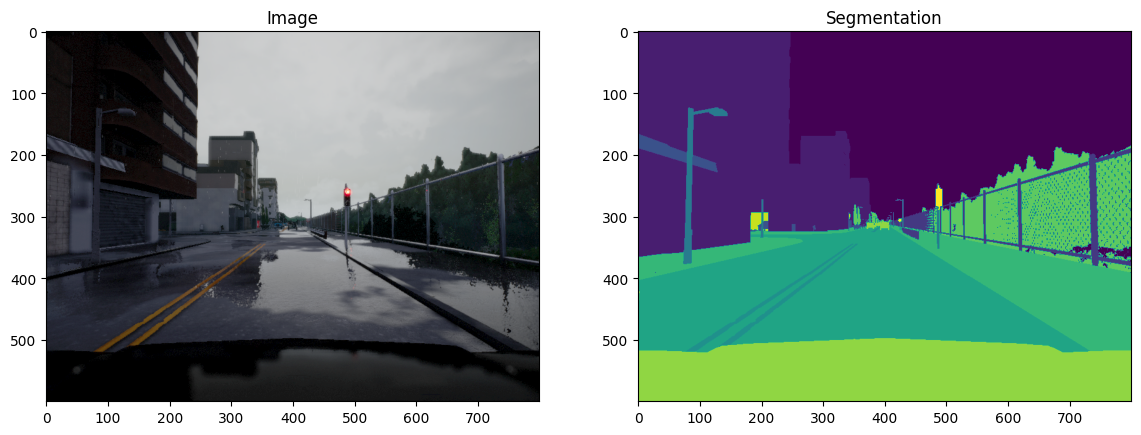

In [ ]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

⏰⏰⏰⏰⏰⏰

**Question**

What is the size of each mask? How many classes are there in this data?

Each mask has `(600,800)` size and there's `13` classes

<a name='2-1'></a>
### 2.1 - Split Your Dataset into Unmasked and Masked Images

Convert the image_list and mask_list into a single tf.data.Dataset object.

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(((image_list), (mask_list))) ############
for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/gdrive/MyDrive/dataA/dataA/CameraRGB/02_00_001.png', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/dataA/dataA/CameraSeg/02_00_150.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocess Your Data

In [5]:
def process_path(image_path, mask_path):
    """
    Write a function that takes in the image and mask path and returns the image and mask as TENSORS
    - Use tensorflow functions only
    - Keep track of what the dimensions should be
    - The mask should have 1 channel
    - The image should have 3 channels
    """
    ## START CODE HERE ####
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    # mask = tf.image.convert_image_dtype(mask, tf.float32) #This is the reason why i was late
    mask = mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    #### END CODE HERE ####

    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
# print(next(iter(image_ds))[0].shape, next(iter(image_ds))[1].shape)
processed_image_ds = image_ds.map(preprocess)

<a name='3'></a>
## 3 - U-Net

<a name='3-1'></a>
### 3.1 - Model Details

<a href="https://ibb.co/8bfBpz5"><img src="https://i.ibb.co/QkTcR8N/unet.png" alt="unet" border="0"></a><br /><a target='_blank' href='https://emoticoncentral.com/category/classical-building'></a><br />
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block)


<a href="https://ibb.co/BGGWBGc"><img src="https://i.ibb.co/XDD0tDj/encoder.png" alt="encoder" border="0"></a>
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling.

The function will  return two tensors:
- `next_layer`: That will go into the next block.
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

<a name='ex-1'></a>
### Exercise 1 - conv_block

Implement `conv_block(...)`. Here are the instructions for each step in the `conv_block`, or contracting block:

* Add 2 **Conv2D** layers with `n_filters` filters with `kernel_size` set to 3, `kernel_initializer` set to ['he_normal'](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), `padding` set to 'same' and 'relu' activation.
* if `dropout_prob` > 0, then add a Dropout layer with parameter `dropout_prob`
* If `max_pooling` is set to True, then add a MaxPooling2D layer with 2x2 pool size

In [6]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, kernel_size=(3,3),
                  kernel_initializer="he_normal",
                  padding="same", activation="relu")(inputs)
    conv = Conv2D(n_filters, kernel_size=(3,3),
                  kernel_initializer="he_normal",
                  padding="same", activation="relu")(conv)
    ### END CODE HERE

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
        next_layer = conv
         ### END CODE HERE


    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        ### END CODE HERE

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [7]:
#####################################################

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.


<a href="https://ibb.co/0rGzrk1"><img src="https://i.ibb.co/VTqkTdb/decoder.png" alt="decoder" border="0"></a>
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder.

Here you'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer. You can read more about it [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)


<a name='ex-2'></a>
### Exercise 2 - upsampling_block

Implement `upsampling_block(...)`.

For the function `upsampling_block`:
* Takes the arguments `expansive_input` (which is the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer)
* The number of filters here is the same as in the downsampling block you completed previously
* Your `Conv2DTranspose` layer will take `n_filters` with shape (3,3) and a stride of (2,2), with padding set to `same`. It's applied to `expansive_input`, or the input tensor from the previous layer.

This block is also where you'll concatenate the outputs from the encoder blocks, creating skip connections.

* Concatenate your Conv2DTranspose layer output to the contractive input, with an `axis` of 3. In general, you can concatenate the tensors in the order that you prefer. But for the grader, it is important that you use `[up, contractive_input]`

For the final component, set the parameters for two Conv2D layers to the same values that you set for the two Conv2D layers in the encoder (ReLU activation, He normal initializer, `same` padding).


In [8]:
# UNQ_C2
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    ### START CODE HERE
    Tconv = Conv2DTranspose(n_filters, strides=2,
                  kernel_size=(3,3),padding='same')(expansive_input)
    concatenated = concatenate([Tconv, contractive_input], axis = 3)
    conv = Conv2D(n_filters, kernel_size=(3,3),padding='same',
                                  activation='relu',
                                  kernel_initializer="he_normal")(concatenated)
    conv = Conv2D(n_filters, kernel_size=(3,3),padding='same',
                                  activation='relu',
                                  kernel_initializer="he_normal")(conv)
    ### END CODE HERE
    # upsampled = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same', activation='relu',
    #                                 kernel_initializer='he_normal')(expansive_input)

    return conv

In [9]:
###########################################

<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. That's because there are **23 possible labels for each pixel in this self-driving car dataset.**

<a name='ex-3'></a>
### Exercise 3 - unet_model

For the function `unet_model`, specify the input shape, number of filters, and number of classes (23 in this case).

For the first half of the model:

* Begin with a conv block that takes the inputs of the model and the number of filters
* Then, chain the first output element of each block to the input of the next convolutional block
* Next, double the number of filters at each step
* Beginning with `conv_block4`, add `dropout` of 0.3
* For the final conv_block, set `dropout` to 0.3 again, and turn off max pooling. (Here `n_filters=n_filters* 16`)

For the second half:
* From here, at each step, use half the number of filters of the previous block
* Use cblock5 as expansive_input and cblock4 as contractive_input, with `n_filters` * 8. This is your bottleneck layer.
* Chain the output of the previous block as expansive_input and the corresponding contractive block output.
* Note that you must use the second element of the contractive block before the max pooling layer.
* `conv9` is a Conv2D layer with ReLU activation, He normal initializer, `same` padding
* Finally, `conv10` is a Conv2D that takes the number of classes as the filter, a kernel size of 1, and "same" padding. The output of `conv10` is the output of your model.

In [10]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE

    # Chain the first element of the output of each block to be the input of the next conv_block.
    # Double the number of filters at each new step
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling = False)

    ### END CODE HERE

    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = upsampling_block(ublock6,cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1], n_filters)

    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 (3,3),
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filters, kernel size of 1 and a 'same' padding and no activation !!!

    ### START CODE HERE
    conv10 = Conv2D(n_classes, (1,1), padding="same", activation="linear")(conv9)

    ### END CODE HERE

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

⏰⏰⏰⏰⏰⏰

**Question**

Why did we put the last layer's number of filters as n_classes? Why is the kernel size 1? What's this operation called?

a. Because at the last layer the output will be the probability of belonging to a certain class

b. This layer combines the feature maps from the previous layers into a unified output map. Employing a 1x1 filter decreases the number of feature maps and compresses the information they contain. This reduction aids in improving the computational costs of the model and reduces the risk of overfitting.

c. Point-wise convolution


In [11]:
# import outputs
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
#############################

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [14]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels), n_classes=13)

### Check out the model summary below!

In [15]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d_40 (Conv2D)          (None, 96, 128, 32)          896       ['input_3[0][0]']             
                                                                                                  
 conv2d_41 (Conv2D)          (None, 96, 128, 32)          9248      ['conv2d_40[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 48, 64, 32)           0         ['conv2d_41[0][0]']           
 g2D)                                                                                       

<a name='3-6'></a>
### 3.6 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability.

In [16]:
### Write the code that compiles the unet model
### Use the correct loss function !!! , adam optimizer and accuracy as the metric
unet.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer="adam", metrics=['accuracy'])

⏰⏰⏰⏰⏰⏰

**Question**

I have no activations in the last layer so what does the loss function you chose do to handle this?

ANSWER

This loss function that I used converts the raw_logits into probabilities and it internally applies the softmax activation to the logits before computing the crossentropy.

<a name='3-7'></a>
### 3.7 - Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible.

In [17]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(600, 800, 1)


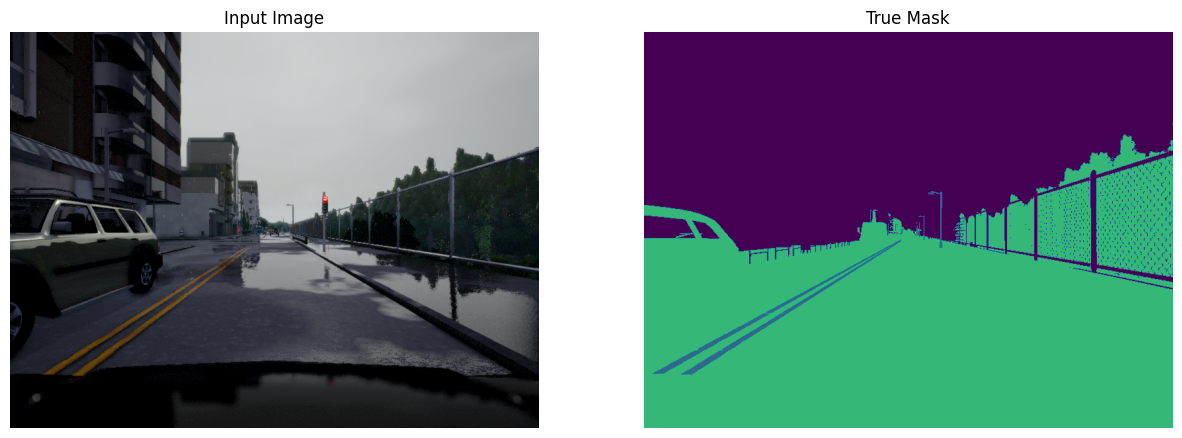

In [18]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


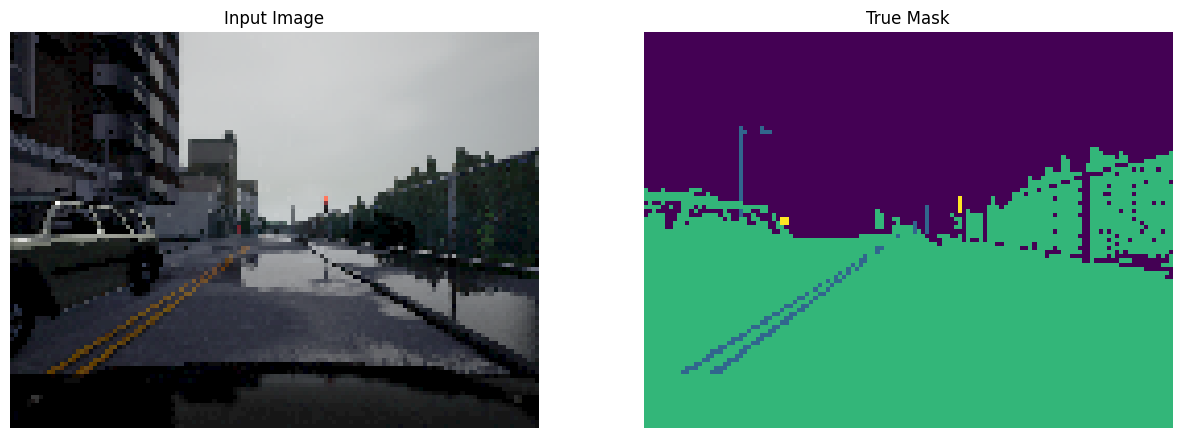

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## 4 - Train the Model

In [19]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
32/32 [==============================] - 198s 2s/step - loss: 1.7299 - accuracy: 0.4849
Epoch 2/40
32/32 [==============================] - 5s 148ms/step - loss: 0.7708 - accuracy: 0.6489
Epoch 3/40
32/32 [==============================] - 5s 151ms/step - loss: 0.4623 - accuracy: 0.8315
Epoch 4/40
32/32 [==============================] - 5s 148ms/step - loss: 0.4134 - accuracy: 0.8375
Epoch 5/40
32/32 [==============================] - 5s 148ms/step - loss: 0.4081 - accuracy: 0.8369
Epoch 6/40
32/32 [==============================] - 5s 152ms/step - loss: 0.3982 - accuracy: 0.8385
Epoch 7/40
32/32 [==============================] - 5s 150ms/step - loss: 0.3880 - accuracy: 0.8395
Epoch 8/40
32/32 [==============================] - 5s 149ms/step - loss: 0.3806 - accuracy: 0.8403
Epoch 9/40
32/32 [==============================] - 5s 150ms/step - loss: 0.3794

<a name='4-1'></a>
### 4.1 - Create Predicted Masks

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [20]:
def create_mask(pred_mask):
    ### Start code here
    pred_mask = tf.argmax(pred_mask, axis=-1)#############
    pred_mask = pred_mask[..., tf.newaxis] # What does this do?
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how your model did!

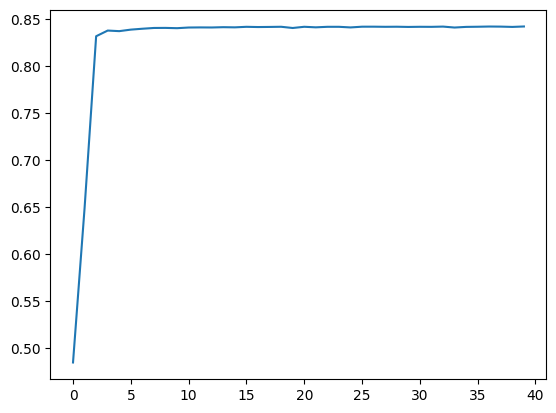

In [21]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
### 4.3 - Show Predictions

Next, check your predicted masks against the true mask and the original input image:

In [22]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 692ms/step


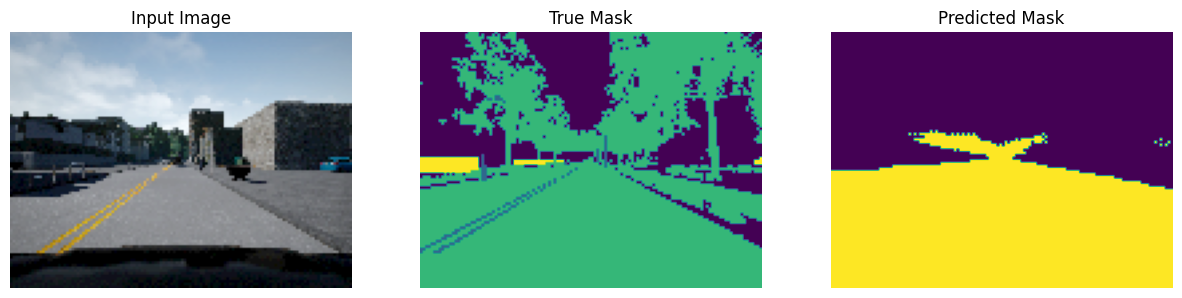

1/1 [==============================] - 0s 52ms/step


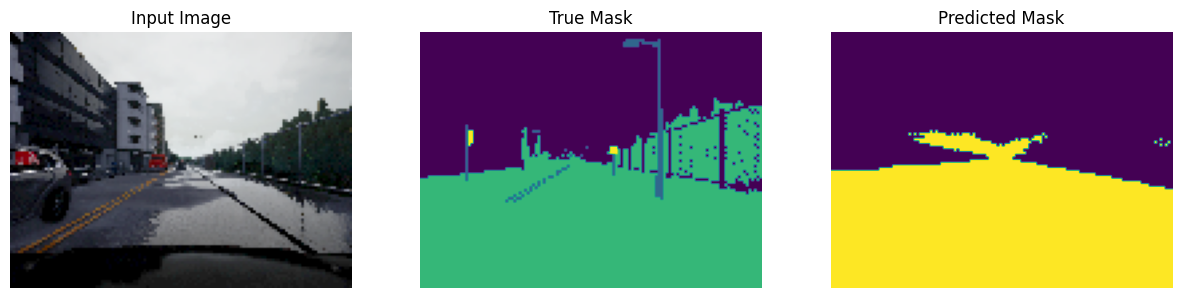

1/1 [==============================] - 0s 91ms/step


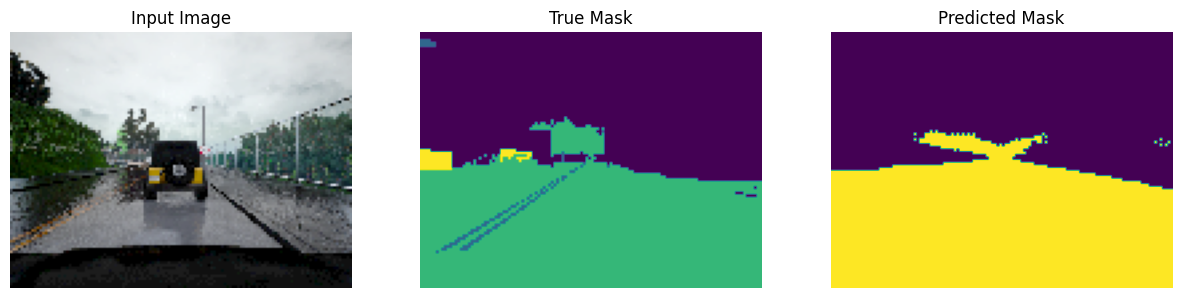

1/1 [==============================] - 0s 25ms/step


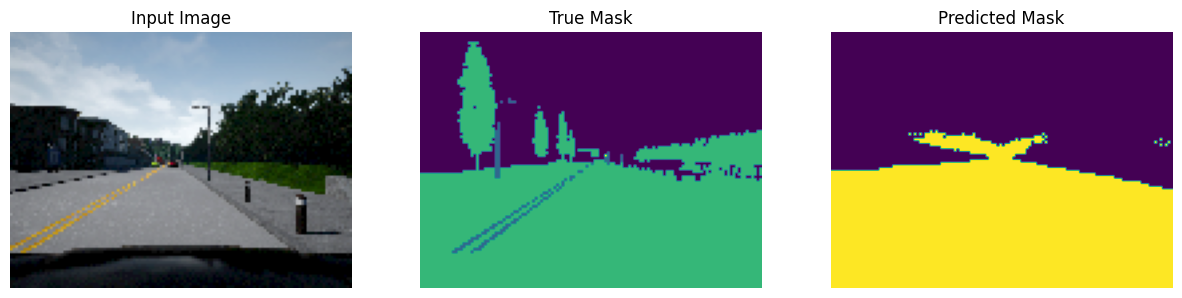

1/1 [==============================] - 0s 24ms/step


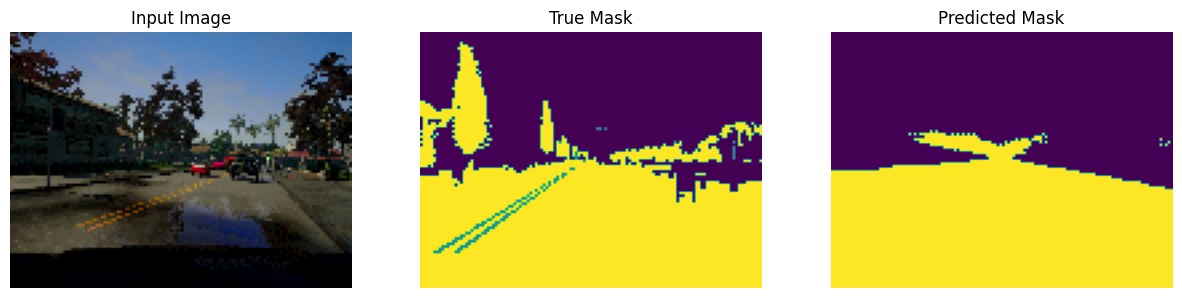

1/1 [==============================] - 0s 27ms/step


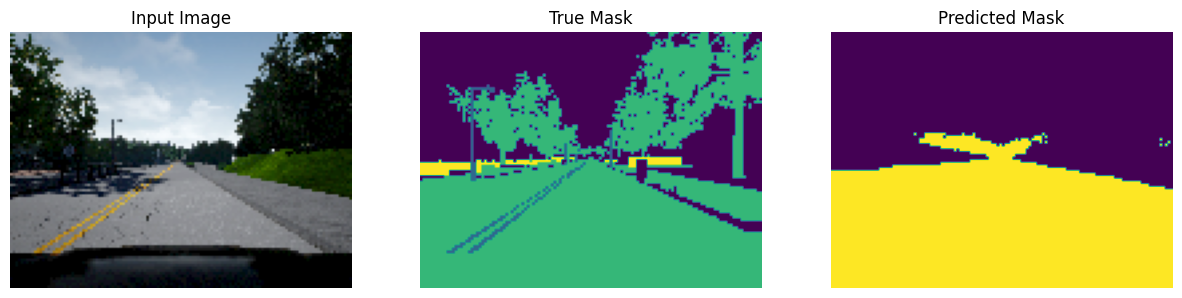

In [23]:
show_predictions(train_dataset, 6)